In [1]:
import os, math, random, argparse, itertools
from pathlib import Path
from collections import defaultdict
from typing import List, Tuple

import numpy as np
from PIL import Image, ImageFile
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torchvision.transforms.functional import InterpolationMode
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# VARIABLE AND HYPERPARAMETER INITIALISATION

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

# Dataset root folder
SOURCE = Path(r"")

# Classes
CLASSES_RAW = ["bench press", "deadlift", "squat", "leg extension", "push up", "shoulder press"]
CLASSES = ["bench_press", "deadlift", "squat", "leg_extension", "push_up", "shoulder_press"] 

# Training / preprocessing knobs
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20
BASE_LR = 3e-4
WEIGHT_DECAY = 1e-4
PATIENCE = 5
LABEL_SMOOTHING = 0.1
USE_MIXUP = True
MIXUP_ALPHA = 0.4
MODEL_NAME = "efficientnet_b0"   # choices: 'resnet18', 'efficientnet_b0', 'vgg16', 'alexnet', 'lenet'
OUT_WEIGHTS = "sbd_best.pt"

# Demo / deployment toggles (optional)
EXPORT_ONNX = ""          # e.g., "sbd.onnx" to export ONNX; "" to skip
LAUNCH_GRADIO = False     # True to launch a quick demo UI after training
ImageFile.LOAD_TRUNCATED_IMAGES = True

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# PREPROCESSING — transforms

train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE), interpolation=InterpolationMode.BICUBIC),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomApply([transforms.ColorJitter(0.2,0.2,0.2,0.05)], p=0.5),
    transforms.RandomRotation(10, interpolation=InterpolationMode.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])
eval_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE), interpolation=InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

In [ ]:
# 2) DATA ANNOTATION / INGEST (OPTIONAL)

def list_images(dir_path: Path) -> List[Path]:
    exts = (".jpg",".jpeg",".png",".webp",".bmp")
    return [dir_path/f for f in os.listdir(dir_path) if f.lower().endswith(exts)]

def ingest_own_data(own_root: Path, source_root: Path):
    """Copy your own annotated images into the SOURCE class folders.
       Expected own_root has subfolders: bench_press, deadlift, squat."""
    mapping = {
        "bench_press": "bench press",
        "deadlift": "deadlift",
        "squat": "squat",
        "leg_extension": "leg extension",
        "push_up": "push up",
        "shoulder_press": "shoulder press",
    }
    for norm, raw in mapping.items():
        src = own_root/norm
        dst = source_root/raw
        if not src.exists(): 
            print(f"[ingest] Skip: {src} not found")
            continue
        dst.mkdir(parents=True, exist_ok=True)
        imgs = list_images(src)
        for p in imgs:
            shutil.copy2(p, dst / p.name)
        print(f"[ingest] Copied {len(imgs)} from {src} -> {dst}")
    print("[ingest] Done.")



In [ ]:
# 3) DATASET SPLIT — random, stratified, non-overlapping (Option B)
#     No folder rewriting; we split indices in memory per class.

def stratified_split(paths: List[Path], labels: List[int], splits=(0.70,0.15,0.15), seed=SEED):
    random.seed(seed)
    by_class = defaultdict(list)
    for p, y in zip(paths, labels): by_class[y].append(p)
    for k in by_class: random.shuffle(by_class[k])

    train_p, val_p, test_p = [], [], []
    train_y, val_y, test_y = [], [], []
    for y, arr in by_class.items():
        n = len(arr); n_train = int(n*splits[0]); n_val = int(n*splits[1])
        t, v, te = arr[:n_train], arr[n_train:n_train+n_val], arr[n_train+n_val:]
        train_p += t; val_p += v; test_p += te
        train_y += [y]*len(t); val_y += [y]*len(v); test_y += [y]*len(te)
    return (train_p, train_y), (val_p, val_y), (test_p, test_y)

def gather_paths_and_labels(source: Path):
    class_to_idx = {name:i for i,name in enumerate(CLASSES_RAW)}
    all_paths, all_labels = [], []
    for raw_name in CLASSES_RAW:
        folder = source/raw_name
        assert folder.exists(), f"Missing folder: {folder}"
        files = list_images(folder)
        all_paths += files
        all_labels += [class_to_idx[raw_name]]*len(files)
    return all_paths, all_labels

class SimpleImageDataset(Dataset):
    def __init__(self, paths: List[Path], labels: List[int], tfm):
        self.paths = paths; self.labels = labels; self.tfm = tfm
    def __len__(self): return len(self.paths)
    def __getitem__(self, i):
        img = Image.open(self.paths[i]).convert("RGB")
        return self.tfm(img), self.labels[i]

def count_per_class(labels: List[int]):
    from collections import Counter
    c = Counter(labels)
    return {CLASSES[i]: c.get(i,0) for i in range(len(CLASSES))}


In [ ]:
# 4) MODEL — Baseline → Modern CNNs
# Transfer learning applies fine-tuning and training at all layers

class LeNet5(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 6, 5, padding=2), nn.Sigmoid(), nn.AvgPool2d(2),
            nn.Conv2d(6,16,5),             nn.Sigmoid(), nn.AvgPool2d(2),
            nn.Flatten(),
            nn.Linear(16*53*53,120), nn.Sigmoid(),
            nn.Linear(120,84),       nn.Sigmoid(),
            nn.Linear(84, num_classes)
        )
    def forward(self,x): return self.net(x)

def build_model(name: str, num_classes: int):
    n = name.lower()
    if n == "lenet":
        return LeNet5(num_classes)
    if n == "alexnet":
        m = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)
        m.classifier[6] = nn.Linear(m.classifier[6].in_features, num_classes); return m
    if n == "vgg16":
        m = models.vgg16_bn(weights=models.VGG16_BN_Weights.IMAGENET1K_V1)
        m.classifier[6] = nn.Linear(m.classifier[6].in_features, num_classes); return m
    if n == "resnet18":
        m = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        m.fc = nn.Linear(m.fc.in_features, num_classes); return m
    if n == "efficientnet_b0":
        m = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        m.classifier[1] = nn.Linear(m.classifier[1].in_features, num_classes); return m
    raise ValueError("Unknown model name")

In [ ]:
# 5) TRAINING — label smoothing, mixup, cosine LR (warmup), early stopping

def mixup_data(x, y, alpha=0.4):
    if alpha <= 0: return x, (y,y), 1.0
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0), device=x.device)
    return lam*x + (1-lam)*x[idx], (y, y[idx]), lam

def mixup_criterion(criterion, pred, targets, lam):
    y_a, y_b = targets
    return lam*criterion(pred, y_a) + (1-lam)*criterion(pred, y_b)

@torch.no_grad()
def evaluate(model, loader, criterion, device, split="Val"):
    model.eval()
    total, correct, total_loss = 0, 0, 0.0
    all_preds, all_labels = [], []
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            logits = model(imgs); loss = criterion(logits, labels)
        total_loss += loss.item()*imgs.size(0)
        preds = logits.argmax(1)
        correct += (preds==labels).sum().item()
        total += labels.numel()
        all_preds += preds.cpu().tolist(); all_labels += labels.cpu().tolist()
    acc = correct / max(1,total)
    print(f"[{split}] loss={total_loss/max(1,total):.4f} acc={acc:.4f}")
    return acc, all_labels, all_preds

In [ ]:
# 6) EVALUATION — report + confusion matrix

def plot_confusion(y_true, y_pred, filename="confusion_matrix_test.png"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    plt.imshow(cm, interpolation='nearest')
    plt.title("Confusion Matrix (Test)"); plt.colorbar()
    ticks = np.arange(len(CLASSES)); plt.xticks(ticks, CLASSES, rotation=45); plt.yticks(ticks, CLASSES)
    thr = cm.max()/2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i,j]), ha="center", va="center",
                     color="white" if cm[i,j] > thr else "black")
    plt.tight_layout(); plt.ylabel("True"); plt.xlabel("Predicted")
    plt.savefig(filename, dpi=200)
    print(f"Saved {filename}")

Device: cpu
SOURCE: C:\University\Y2T1\Computer Vision and Deep Learning\Project\Dataset
Split sizes: {'train': 4067, 'val': 869, 'test': 879}
Per-class counts:
  train: {'bench_press': 857, 'deadlift': 660, 'squat': 760, 'leg_extension': 611, 'push_up': 631, 'shoulder_press': 548}
  val  : {'bench_press': 183, 'deadlift': 141, 'squat': 162, 'leg_extension': 131, 'push_up': 135, 'shoulder_press': 117}
  test : {'bench_press': 185, 'deadlift': 143, 'squat': 164, 'leg_extension': 132, 'push_up': 136, 'shoulder_press': 119}
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\Derpi/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth


100.0%
C:\Users\Derpi\AppData\Local\Temp\ipykernel_13708\1830977947.py:46: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
C:\Users\Derpi\AppData\Local\Temp\ipykernel_13708\1830977947.py:56: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 1 train_loss=1.0493


C:\Users\Derpi\AppData\Local\Temp\ipykernel_13708\2923977339.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


[Val] loss=0.4874 acc=0.9908
  ✓ Saved sbd_best.pt (val_acc=0.9908)
Epoch 2 train_loss=0.7843
[Val] loss=0.4594 acc=1.0000
  ✓ Saved sbd_best.pt (val_acc=1.0000)
Epoch 3 train_loss=0.7801
[Val] loss=0.4553 acc=0.9988
Epoch 4 train_loss=0.7427
[Val] loss=0.4394 acc=1.0000
Epoch 5 train_loss=0.7633
[Val] loss=0.4472 acc=1.0000
Epoch 6 train_loss=0.7335
[Val] loss=0.4437 acc=1.0000
Epoch 7 train_loss=0.7390
[Val] loss=0.4460 acc=0.9988
  Early stopping.
[Test] loss=0.4590 acc=0.9989

Classification report (Test):
                precision    recall  f1-score   support

   bench_press     1.0000    0.9946    0.9973       185
      deadlift     0.9931    1.0000    0.9965       143
         squat     1.0000    1.0000    1.0000       164
 leg_extension     1.0000    1.0000    1.0000       132
       push_up     1.0000    1.0000    1.0000       136
shoulder_press     1.0000    1.0000    1.0000       119

      accuracy                         0.9989       879
     macro avg     0.9988    0.999

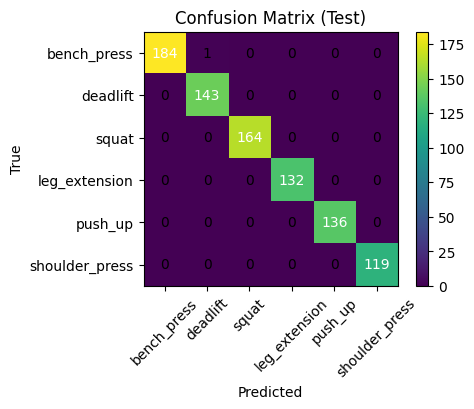

In [ ]:
# MAIN — runs the flow in order

if __name__ == "__main__":
    print("Device:", DEVICE)
    print("SOURCE:", SOURCE.resolve())

    # Gather all labeled images (only these 3 classes)
    all_paths, all_labels = gather_paths_and_labels(SOURCE)

    # Split (stratified, reproducible, NO overlap)
    (train_p, train_y), (val_p, val_y), (test_p, test_y) = stratified_split(all_paths, all_labels, (0.70,0.15,0.15))
    
    # Sanity checks
    def ids(xs): return set(map(lambda p: p.resolve(), xs))
    assert ids(train_p).isdisjoint(ids(val_p)) and ids(train_p).isdisjoint(ids(test_p)) and ids(val_p).isdisjoint(ids(test_p)), \
        "Split overlap detected!"

    print("Split sizes:", {"train": len(train_p), "val": len(val_p), "test": len(test_p)})
    print("Per-class counts:")
    print("  train:", count_per_class(train_y))
    print("  val  :", count_per_class(val_y))
    print("  test :", count_per_class(test_y))

    # Build datasets/loaders
    NUM_WORKERS = 0 
    PIN_MEMORY = False
    train_ds = SimpleImageDataset(train_p, train_y, train_tfms)
    val_ds   = SimpleImageDataset(val_p,   val_y,   eval_tfms)
    test_ds  = SimpleImageDataset(test_p,  test_y,  eval_tfms)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS)
    val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    train_acc_list = []
    val_acc_list = []

    # Build model & training objects
    model = build_model(MODEL_NAME, num_classes=6).to(DEVICE)
    criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)
    optimizer = optim.AdamW(model.parameters(), lr=BASE_LR, weight_decay=WEIGHT_DECAY)
    # cosine LR + 2-epoch warmup
    warmup_epochs = 2
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return (epoch + 1) / warmup_epochs
        prog = (epoch - warmup_epochs) / max(1, (EPOCHS - warmup_epochs))
        return 0.1 + 0.9 * 0.5 * (1 + math.cos(math.pi * prog))
    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
    scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

    # Train with early stopping on Val Acc
    best_val, bad = -1, 0
    for epoch in range(1, EPOCHS+1):
        model.train()
        running = 0.0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                if USE_MIXUP and MIXUP_ALPHA > 0:
                    imgs, targets, lam = mixup_data(imgs, labels, MIXUP_ALPHA)
                    logits = model(imgs)
                    loss = mixup_criterion(criterion, logits, targets, lam)
                else:
                    logits = model(imgs)
                    loss = criterion(logits, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer); scaler.update()
            running += loss.item()*imgs.size(0)

        scheduler.step()
        print(f"Epoch {epoch} train_loss={running/len(train_loader.dataset):.4f}")

        val_acc, y_true, y_pred = evaluate(model, val_loader, criterion, DEVICE, "Val")
        train_acc, _, _ = evaluate(model, train_loader, criterion, DEVICE, "Train")
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        
        if val_acc > best_val:
            best_val, bad = val_acc, 0
            torch.save({"model": model.state_dict(), "classes": CLASSES}, OUT_WEIGHTS)
            print(f"  ✓ Saved {OUT_WEIGHTS} (val_acc={best_val:.4f})")
        else:
            bad += 1
            if bad >= PATIENCE:
                print("  Early stopping.")
                break

    # Final test
    ckpt = torch.load(OUT_WEIGHTS, map_location=DEVICE)
    model.load_state_dict(ckpt["model"]); model.eval()
    test_acc, y_true, y_pred = evaluate(model, test_loader, criterion, DEVICE, "Test")

    print("\nClassification report (Test):")
    print(classification_report(y_true, y_pred, target_names=CLASSES, digits=4))
    plot_confusion(y_true, y_pred, "confusion_matrix_test.png")

In [ ]:
# PLOT TRAINING AND VALIDATION ACCURACY OVER EPOCHS

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_acc_list)+1), train_acc_list, marker='o', label='Train Accuracy')
plt.plot(range(1, len(val_acc_list)+1), val_acc_list, marker='s', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# TEST SINGLE IMAGE FROM TEST PATH

import os
from pathlib import Path
import torch
from PIL import Image
import matplotlib.pyplot as plt

# Test set root folder
test_path = Path(r"")

def test_single_image(image_path, model, eval_tfms, classes, device):
    """
    Test a single image and return prediction with confidence
    """
    # Load and preprocess image
    image = Image.open(image_path).convert("RGB")
    
    # Apply transforms
    input_tensor = eval_tfms(image).unsqueeze(0).to(device)
    
    # Make prediction
    model.eval()
    with torch.no_grad():
        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            logits = model(input_tensor)
            probabilities = torch.softmax(logits, dim=1)
            confidence, predicted_class = torch.max(probabilities, 1)
    
    predicted_label = classes[predicted_class.item()]
    confidence_score = confidence.item()
    
    # Display results
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f'Predicted: {predicted_label} (Confidence: {confidence_score:.4f})')
    plt.tight_layout()
    plt.show()
    
    # Print all class probabilities
    print(f"Image: {image_path.name}")
    print(f"Predicted Class: {predicted_label}")
    print(f"Confidence: {confidence_score:.4f}")
    print("\nAll class probabilities:")
    for i, class_name in enumerate(classes):
        prob = probabilities[0][i].item()
        print(f"  {class_name}: {prob:.4f}")
    
    return predicted_label, confidence_score

# Load the trained model (assuming sbd_best.pt exists)
if os.path.exists(OUT_WEIGHTS):
    # Load checkpoint
    ckpt = torch.load(OUT_WEIGHTS, map_location=DEVICE)
    
    # Build model with same architecture
    model = build_model(MODEL_NAME, num_classes=6).to(DEVICE)
    model.load_state_dict(ckpt["model"])
    model.eval()
    
    # Get available image files from test path
    if test_path.exists():
        image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.webp']
        available_images = []
        
        # Search recursively for images
        for ext in image_extensions:
            available_images.extend(test_path.rglob(f'*{ext}'))
            #available_images.extend(test_path.rglob(f'*{ext.upper()}'))
        
        if available_images:
            print(f"Found {len(available_images)} images in {test_path}")
            
            # # Select a random image for testing
            # random_image = random.choice(available_images)
            # print(f"Testing random image: {random_image}")
            
            # # Test the image
            # predicted_label, confidence = test_single_image(
            #     random_image, model, eval_tfms, CLASSES, DEVICE
            # )
            
        else:
            print(f"No images found in {test_path}")
            print("Please check if the path exists and contains image files")
            
    else:
        print(f"Test path does not exist: {test_path}")
        print("Please verify the path is correct")
        
else:
    print(f"Model weights file '{OUT_WEIGHTS}' not found.")
    print("Please train the model first or ensure the weights file exists.")

# Alternative: Test specific image by name
def test_specific_image(image_name):
    """Test a specific image by name"""
    image_path = test_path / image_name
    if image_path.exists():
        predicted_label, confidence = test_single_image(
            image_path, model, eval_tfms, CLASSES, DEVICE
        )
        return predicted_label, confidence
    else:
        print(f"Image {image_name} not found in {test_path}")
        return None, None


Found 35 images in C:\University\Y2T1\Computer Vision and Deep Learning\Project\test_set


C:\Users\Derpi\AppData\Local\Temp\ipykernel_13708\3705110576.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


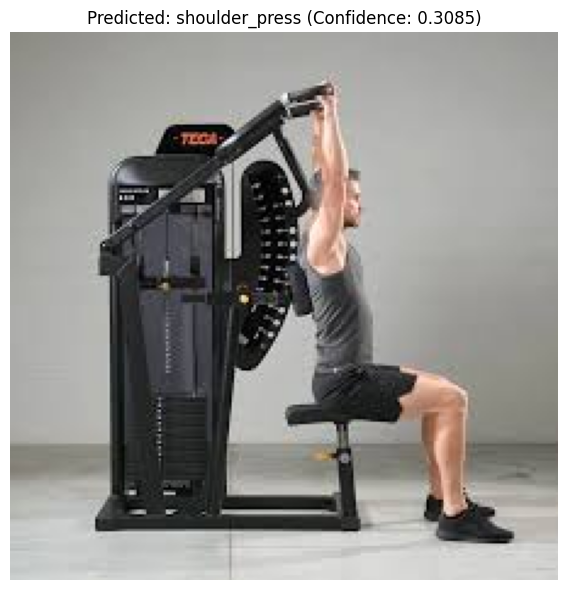

Image: test_ohp_3.jpg
Predicted Class: shoulder_press
Confidence: 0.3085

All class probabilities:
  bench_press: 0.0081
  deadlift: 0.0445
  squat: 0.2842
  leg_extension: 0.2620
  push_up: 0.0927
  shoulder_press: 0.3085


('shoulder_press', 0.308512806892395)

In [ ]:
#Test single image 

test_specific_image("test_image.jpg")